# Libraries

In [1]:
import pandas as pd
import inflection
import missingno as msno
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats
from scipy import stats as ss
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
from IPython.display import Image
from utils import *

import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CDSView, IndexFilter
from bokeh.layouts import row, column
from scipy.stats import gaussian_kde
from bokeh.models import RangeSlider

from sklearn import preprocessing as pp
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN

import random
from sklearn import metrics as m
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve
#from sklearn.metrics import plot_precision_recall_curve

from scikitplot import metrics as mt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import category_encoders

from datetime import datetime, timedelta
import pickle

# Loading Data

In [2]:
pwd

'/Users/lucasquemelli/Documents/repos/stock_price_prediction'

In [3]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/stock_price_prediction/NFLX.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,326.100006,329.980011,324.779999,329.809998,329.809998,4485800
1,2020-01-03,326.779999,329.859985,325.529999,325.899994,325.899994,3806900
2,2020-01-06,323.119995,336.359985,321.200012,335.829987,335.829987,5663100
3,2020-01-07,336.470001,336.700012,330.299988,330.750000,330.750000,4703200
4,2020-01-08,331.489990,342.700012,331.049988,339.260010,339.260010,7104500


In [4]:
cols_old = data.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

data.columns = cols_new

data.rename(columns={"adj close": "adj_close"}, inplace=True)

In [5]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')

# Deduplication Test

Since this analysis should be at date level, would it be affordable to have more rows than dates?

In [6]:
data["date"].nunique()

982

In [7]:
data.shape[0]

982

Since we cannot use data from a far past to predict stock price of the next month or week, we used only data from the last 3 years. Each row represents data from each date.

# 1. Data Description

In [8]:
data.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object

In [9]:
data.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [10]:
data["date"] = pd.to_datetime(data["date"])

In [11]:
data.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int64
dtype: object

# High and low prices of Netflix stock

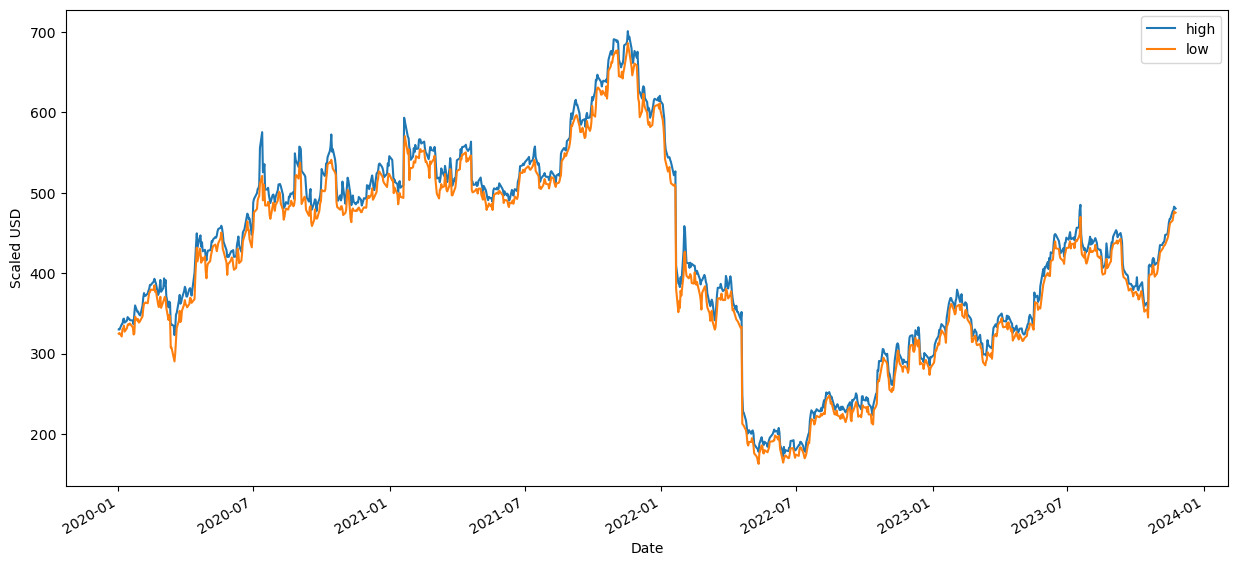

In [12]:
plt.figure(figsize=(15, 7))

plt.plot(data["date"], data["high"], label="high")
plt.plot(data["date"], data["low"], label="low")
plt.xlabel("Date")
plt.ylabel("Scaled USD")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Open and close prices of Netflix stock

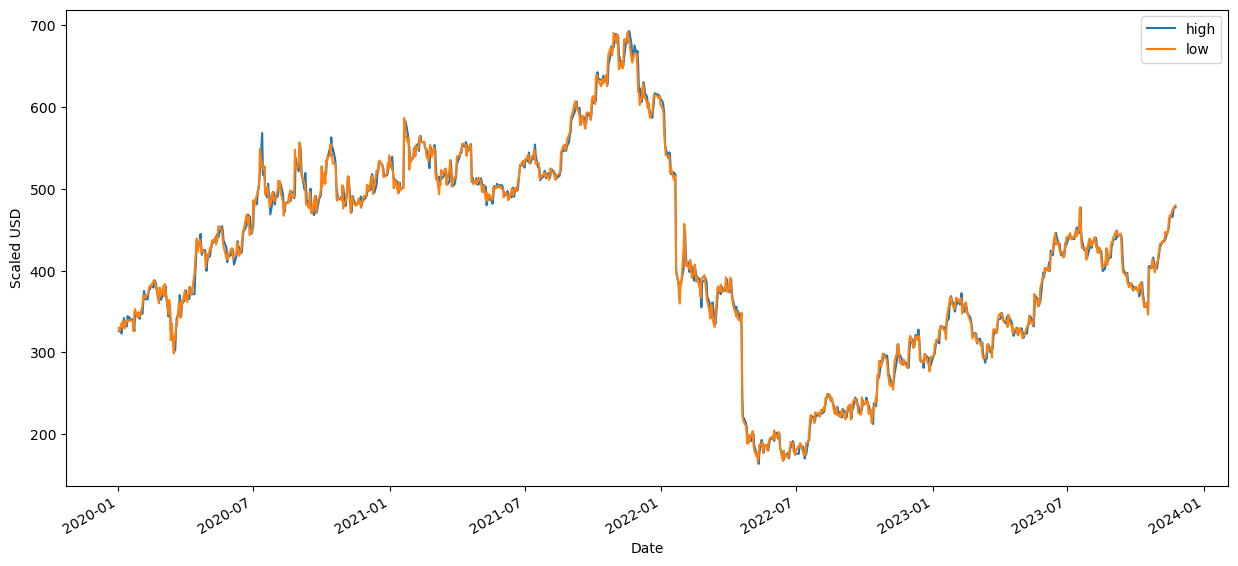

In [13]:
plt.figure(figsize=(15, 7))

plt.plot(data["date"], data["open"], label="high")
plt.plot(data["date"], data["close"], label="low")
plt.xlabel("Date")
plt.ylabel("Scaled USD")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Libraries for Stock Prediction

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit 

2023-11-28 19:23:39.196876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preprocessing

In [15]:
data.head()

,date,open,high,low,close,adj_close,volume
0,2020-01-02,326.100006,329.980011,324.779999,329.809998,329.809998,4485800
1,2020-01-03,326.779999,329.859985,325.529999,325.899994,325.899994,3806900
2,2020-01-06,323.119995,336.359985,321.200012,335.829987,335.829987,5663100
3,2020-01-07,336.470001,336.700012,330.299988,330.750000,330.750000,4703200
4,2020-01-08,331.489990,342.700012,331.049988,339.260010,339.260010,7104500


In [16]:
# Selecting the target variable "close" from the 'data' DataFrame
target_y = data["close"]

# Selecting the first three columns of the 'data' DataFrame as features
data = data.iloc[:, 0:3]

In [17]:
data.head()

,date,open,high
0,2020-01-02,326.100006,329.980011
1,2020-01-03,326.779999,329.859985
2,2020-01-06,323.119995,336.359985
3,2020-01-07,336.470001,336.700012
4,2020-01-08,331.489990,342.700012


In [48]:
target_y.head()

0    329.809998
1    325.899994
2    335.829987
3    330.750000
4    339.260010
Name: close, dtype: float64

Scikit-learn also provides a popular MinMaxScaler preprocessing module. However, considering the context, stock prices might max out or minimise on different days, and using those values to influence others might not be great. The change in values from using either of these methods would not be much, so we stick to StandardScaler.

In [51]:
# Feature scaling using StandardScaler from the preprocessing module
sc = pp.StandardScaler()

# Scaling the features in 'x_feat' using the StandardScaler
data["open"] = sc.fit_transform(data[["open"]].values)
data["high"] = sc.fit_transform(data[["high"]].values)

target_y = sc.fit_transform(target_y.values.reshape(-1, 1))

# into DataFrame
data = pd.DataFrame(columns=data.columns,
                      data=data,
                      index=data.index)

In [52]:
data.head()

,date,open,high
0,2020-01-02,-0.758124,-0.777216
1,2020-01-03,-0.752562,-0.778193
2,2020-01-06,-0.782500,-0.725252
3,2020-01-07,-0.673299,-0.722483
4,2020-01-08,-0.714035,-0.673614


In [53]:
target_y

array([[-0.73056305],
       [-0.76263562],
       [-0.68118292],
       [-0.7228525 ],
       [-0.65304748],
       [-0.68257724],
       [-0.73679718],
       [-0.65583638],
       [-0.65772309],
       [-0.65460602],
       [-0.65829733],
       [-0.64968435],
       [-0.66248079],
       [-0.76181531],
       [-0.56823165],
       [-0.53903007],
       [-0.62335377],
       [-0.5770907 ],
       [-0.62105702],
       [-0.58348879],
       [-0.60522588],
       [-0.49932905],
       [-0.4090173 ],
       [-0.40360349],
       [-0.42591483],
       [-0.42739151],
       [-0.39211977],
       [-0.37062875],
       [-0.31878765],
       [-0.30738603],
       [-0.31558873],
       [-0.25505279],
       [-0.26809506],
       [-0.26965358],
       [-0.31829551],
       [-0.41156012],
       [-0.48218545],
       [-0.32510389],
       [-0.38687017],
       [-0.40885333],
       [-0.31025702],
       [-0.41098612],
       [-0.28778147],
       [-0.37809322],
       [-0.40934548],
       [-0

In [76]:
df = pd.concat([data, pd.DataFrame(target_y, columns=['target_y'])], axis=1)
df.rename(columns={"target_y": "target"}, inplace=True)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

df.drop(columns=["date"], inplace=True)

df.head()

,open,high,target,year,month,day
0,-0.758124,-0.777216,-0.730563,2020,1,2
1,-0.752562,-0.778193,-0.762636,2020,1,3
2,-0.782500,-0.725252,-0.681183,2020,1,6
3,-0.673299,-0.722483,-0.722853,2020,1,7
4,-0.714035,-0.673614,-0.653047,2020,1,8


# LSTM train and test split

So, the next step would be to split it into training and testing sets. The training of an LSTM model requires a window or a timestep of data in each training step. For instance, the LSTM will take 10 data samples to predict the 10th one by weighing the first nine input samples in one step. So, we need a different approach than the train_test_split provided by scikit-learn.

Let’s define a splitting function called lstm_split() which will make windows of size “n_steps” starting from the first sample of data and ending at n_steps’th sample (if n_steps=10, then the 10th sample) from the end. We understand the latter part because, for each time step, LSTM will take n_steps-1 samples for training and predict the last sample. Loss calculation is done based on the error in this prediction. So if n_steps=10, you cannot use the last 9 samples to predict anything because the “10th” data point for the current step does not exist in the dataset.

The function below takes the entire data and creates windows of size n_steps starting from the beginning. The target y will contain the target value corresponding to the n_steps’th index. So if n_steps is 10, the first element in X will have features from 10 data samples, and y will contain the target of the 10th data sample.

We split our data into training and testing sets. Shuffling is not permitted in time-series datasets. In the beginning, we take two steps worth of past data to predict the current value. Thus, the model will look at yesterday’s and today’s values to predict today’s closing price.

In [77]:
# Assuming you have a DataFrame 'df' with a column 'stock_price'
train_size = int(len(df) * 0.8)  # 80% for training
train, test = df[:train_size], df[train_size:]

In [78]:
print(X_train.shape, X_test.shape, y_test.shape)

(783, 2, 1) (195, 2, 1) (195,)


Note above that the size of X1 is n_steps less than that of the original dataset. We cannot use the last two samples of the original set during training or prediction as we do not have their corresponding ground truth values.

In [79]:
X_test

array([[[Timestamp('2023-02-14 00:00:00')],
        [Timestamp('2023-02-15 00:00:00')]],

       [[Timestamp('2023-02-15 00:00:00')],
        [Timestamp('2023-02-16 00:00:00')]],

       [[Timestamp('2023-02-16 00:00:00')],
        [Timestamp('2023-02-17 00:00:00')]],

       [[Timestamp('2023-02-17 00:00:00')],
        [Timestamp('2023-02-21 00:00:00')]],

       [[Timestamp('2023-02-21 00:00:00')],
        [Timestamp('2023-02-22 00:00:00')]],

       [[Timestamp('2023-02-22 00:00:00')],
        [Timestamp('2023-02-23 00:00:00')]],

       [[Timestamp('2023-02-23 00:00:00')],
        [Timestamp('2023-02-24 00:00:00')]],

       [[Timestamp('2023-02-24 00:00:00')],
        [Timestamp('2023-02-27 00:00:00')]],

       [[Timestamp('2023-02-27 00:00:00')],
        [Timestamp('2023-02-28 00:00:00')]],

       [[Timestamp('2023-02-28 00:00:00')],
        [Timestamp('2023-03-01 00:00:00')]],

       [[Timestamp('2023-03-01 00:00:00')],
        [Timestamp('2023-03-02 00:00:00')]],

       [[T

# LSTM Model

In [80]:
X_train.shape[0]

783

In [81]:
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 2  # experiment with this value
X_train, y_train = create_dataset(train.values, time_steps)
X_test, y_test = create_dataset(test.values, time_steps)

# Reshape to (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [82]:
X_train.shape[0]

783

In [29]:
# define model
model = Sequential()
model.add(LSTM(units=1024, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Displaying a summary of the model architecture
lstm.summary()

785

In [84]:
model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
196/196 [==============================] - 14s 64ms/step - loss: 0.0558
Epoch 2/100
196/196 [==============================] - 13s 64ms/step - loss: 0.0189
Epoch 3/100
196/196 [==============================] - 12s 64ms/step - loss: 0.0170
Epoch 4/100
196/196 [==============================] - 13s 69ms/step - loss: 0.0170
Epoch 5/100
196/196 [==============================] - 13s 65ms/step - loss: 0.0177
Epoch 6/100
196/196 [==============================] - 13s 65ms/step - loss: 0.0160
Epoch 7/100
196/196 [==============================] - 13s 65ms/step - loss: 0.0187
Epoch 8/100
196/196 [==============================] - 13s 66ms/step - loss: 0.0147
Epoch 9/100
196/196 [==============================] - 13s 65ms/step - loss: 0.0190
Epoch 10/100
196/196 [==============================] - 13s 68ms/step - loss: 0.0167
Epoch 11/100
196/196 [==============================] - 13s 67ms/step - loss: 0.0142
Epoch 12/100
196/196 [==============================] - 13s 68ms/step - lo

196/196 [==============================] - 12s 62ms/step - loss: 0.0104
Epoch 98/100
196/196 [==============================] - 12s 62ms/step - loss: 0.0102
Epoch 99/100
196/196 [==============================] - 13s 65ms/step - loss: 0.0102
Epoch 100/100
196/196 [==============================] - 13s 65ms/step - loss: 0.0101


# Prediction

In [85]:
predictions = model.predict(X_test)

7/7 [==============================] - 0s 7ms/step


In [86]:
predictions

array([[-0.47994804],
       [-0.49274725],
       [-0.5484548 ],
       [-0.58813936],
       [-0.63012105],
       [-0.6792807 ],
       [-0.77265877],
       [-0.7383733 ],
       [-0.73889756],
       [-0.7555341 ],
       [-0.8378884 ],
       [-0.8046473 ],
       [-0.7918412 ],
       [-0.8248829 ],
       [-0.8515883 ],
       [-0.8307821 ],
       [-0.9397987 ],
       [-1.0224867 ],
       [-0.9593023 ],
       [-0.9831427 ],
       [-0.8913746 ],
       [-0.8472838 ],
       [-0.92523736],
       [-0.87707406],
       [-0.87554973],
       [-0.88804036],
       [-0.7672742 ],
       [-0.70988864],
       [-0.7201905 ],
       [-0.7185957 ],
       [-0.6112855 ],
       [-0.61036927],
       [-0.59656304],
       [-0.5447535 ],
       [-0.56893843],
       [-0.61567533],
       [-0.6476665 ],
       [-0.584771  ],
       [-0.6042314 ],
       [-0.61079174],
       [-0.58796126],
       [-0.6262073 ],
       [-0.6498446 ],
       [-0.7342371 ],
       [-0.7644598 ],
       [-0

In [87]:
y_test

array([-5.21726067e-01, -5.79721319e-01, -6.21111449e-01, -6.64873807e-01,
       -7.16161507e-01, -8.13747553e-01, -7.76365487e-01, -7.77755926e-01,
       -7.95342844e-01, -8.81967651e-01, -8.45239860e-01, -8.32561158e-01,
       -8.67898257e-01, -8.95627888e-01, -8.72806229e-01, -9.88796740e-01,
       -1.07517616e+00, -1.00458383e+00, -1.03288611e+00, -9.32764576e-01,
       -8.89329478e-01, -9.73336661e-01, -9.19922121e-01, -9.20003993e-01,
       -9.33337224e-01, -8.02868186e-01, -7.46263619e-01, -7.58451545e-01,
       -7.56570085e-01, -6.42215654e-01, -6.44015234e-01, -6.29455072e-01,
       -5.74977108e-01, -6.01070912e-01, -6.49822877e-01, -6.83115008e-01,
       -6.16203477e-01, -6.37798450e-01, -6.44506010e-01, -6.20375293e-01,
       -6.60783871e-01, -6.85323484e-01, -7.73584363e-01, -8.04831273e-01,
       -7.83481933e-01, -7.24586765e-01, -7.38492644e-01, -7.96897044e-01,
       -7.72848199e-01, -7.65159104e-01, -7.30803549e-01, -7.67122192e-01,
       -8.28062327e-01, -

In [88]:
# Calculate performance metrics
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 0.07505039864801591
MAPE: 1.3513958021903176


In [93]:
data.head()

,date,open,high
0,2020-01-02,-0.758124,-0.777216
1,2020-01-03,-0.752562,-0.778193
2,2020-01-06,-0.782500,-0.725252
3,2020-01-07,-0.673299,-0.722483
4,2020-01-08,-0.714035,-0.673614


In [95]:
test.head()

,open,high,target,year,month,day
785,-0.500867,-0.502166,-0.483252,2023,2,14
786,-0.508393,-0.509252,-0.471276,2023,2,15
787,-0.521726,-0.520492,-0.559127,2023,2,16
788,-0.579721,-0.622302,-0.581684,2023,2,17
789,-0.621111,-0.661967,-0.667484,2023,2,21


## Scaled Price and Transformed Date

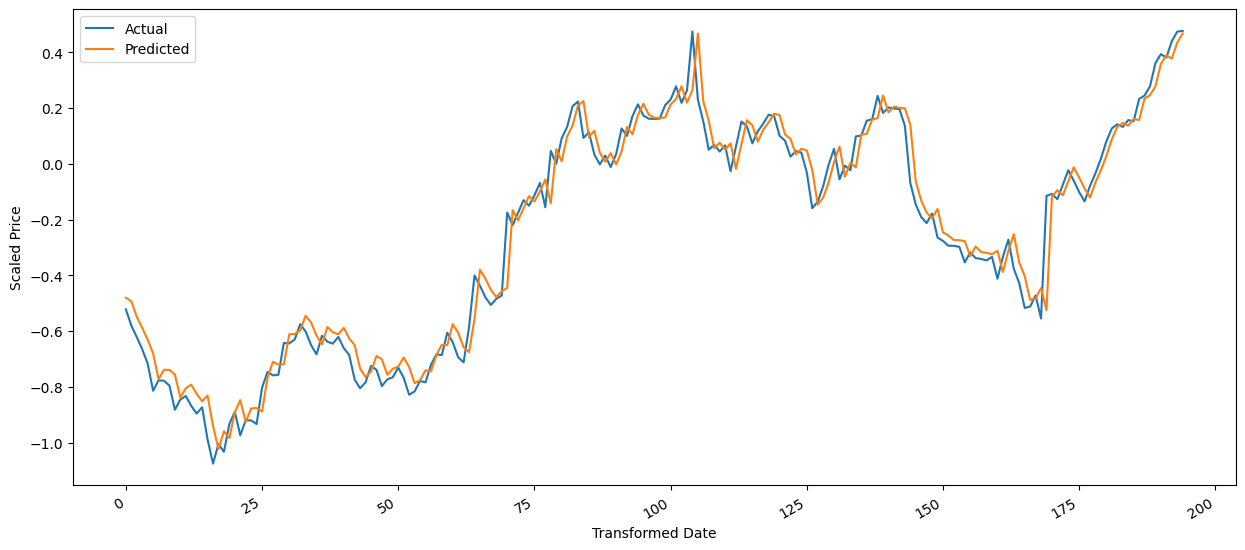

In [112]:
plt.figure(figsize=(15, 7))

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel("Transformed Date")
plt.ylabel("Scaled Price")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Scaled Price

In [96]:
test['date'] = pd.to_datetime(test[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Drop the original year, month, and day columns if needed
test = test.drop(['year', 'month', 'day'], axis=1)

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_34268/2324846269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')


In [97]:
test.head()

,open,high,target,date
785,-0.500867,-0.502166,-0.483252,2023-02-14
786,-0.508393,-0.509252,-0.471276,2023-02-15
787,-0.521726,-0.520492,-0.559127,2023-02-16
788,-0.579721,-0.622302,-0.581684,2023-02-17
789,-0.621111,-0.661967,-0.667484,2023-02-21


In [104]:
# removing last 2 rows to match dimensions :: we removed last two data points for n_steps
test_date = test.iloc[:-2].copy()

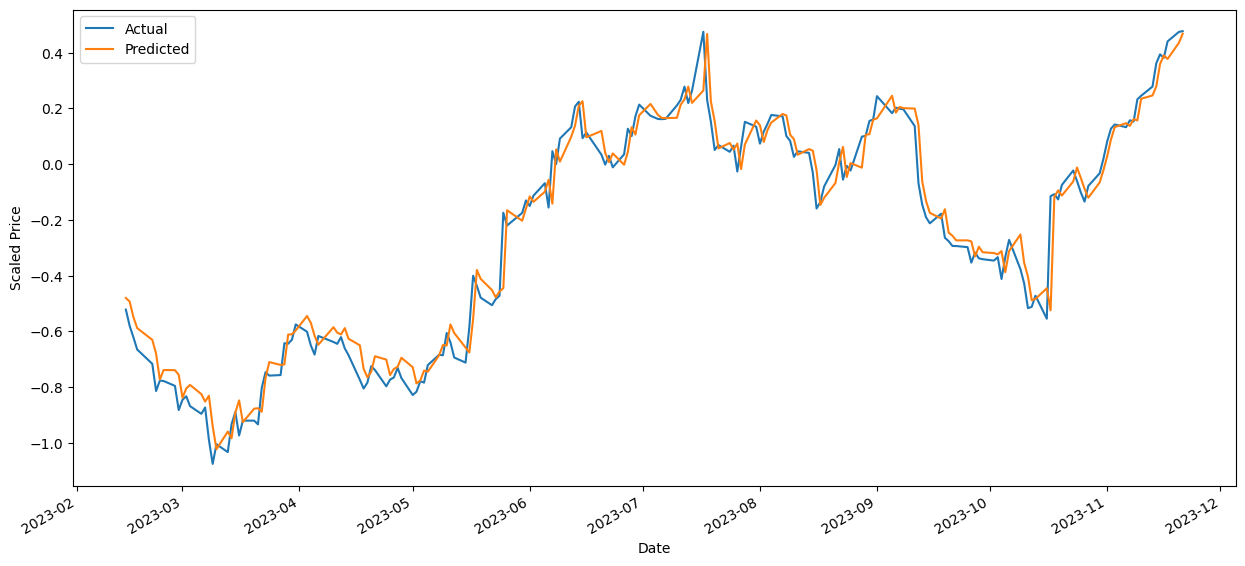

In [113]:
plt.figure(figsize=(15, 7))

plt.plot(test_date["date"], y_test, label='Actual')
plt.plot(test_date["date"], predictions, label='Predicted')
plt.xlabel("Date")
plt.ylabel("Scaled Price")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Real Price and Real Date

In [108]:
# Inverse transform predictions
inverse_transformed_predictions = sc.inverse_transform(predictions)

# Reshape y_test to a 2D array
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse transform y_test
inverse_transformed_y_test = sc.inverse_transform(y_test_reshaped)

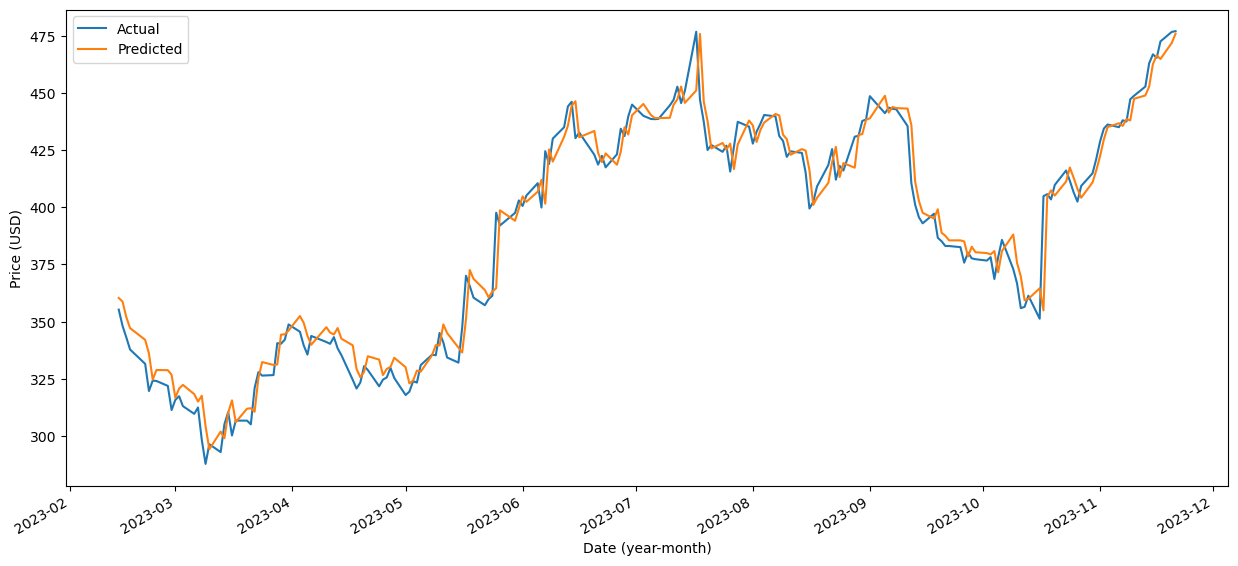

In [114]:
plt.figure(figsize=(15, 7))

plt.plot(test_date["date"], inverse_transformed_y_test, label='Actual')
plt.plot(test_date["date"], inverse_transformed_predictions, label='Predicted')
plt.xlabel("Date (year-month)")
plt.ylabel("Price (USD)")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()